In [4]:
%matplotlib inline

import os
import numpy as np 
import pandas as pd
from glob import glob

USE_CV2 = False
if USE_CV2:
    from cv2 import imread # opencv is much faster, but less accurate
else:
    from skimage.io import imread

import matplotlib.pyplot as plt

from skimage.segmentation import mark_boundaries
from skimage.transform import resize

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dropout, Conv2D, Cropping2D, Conv2DTranspose, Add, Input, Reshape, Permute, Activation

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))


In [5]:
# Data path used in this notebook. 

DATA_DIR = os.path.join('.', 'data')
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'Train/CameraRGB')
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'Train/CameraSeg')

clara_seg_data = pd.DataFrame(dict(image = glob(os.path.join(TRAIN_IMAGE_DIR, '*.*p*g'))))
clara_seg_data['id'] = clara_seg_data['image'].map(lambda x: x.split('/')[-1].split('.')[0])
clara_seg_data['label'] = clara_seg_data['image'].map(lambda x: os.path.join(TRAIN_LABEL_DIR, x.split('/')[-1]))
clara_seg_data.sample(5)

,image,id,label
257,./data/Train/CameraRGB/284.png,284,./data/Train/CameraSeg/284.png
787,./data/Train/CameraRGB/513.png,513,./data/Train/CameraSeg/513.png
945,./data/Train/CameraRGB/924.png,924,./data/Train/CameraSeg/924.png
251,./data/Train/CameraRGB/291.png,291,./data/Train/CameraSeg/291.png
779,./data/Train/CameraRGB/868.png,868,./data/Train/CameraSeg/868.png


## Exploring the Dataset

In [6]:
print ("Total number of examples {}".format(clara_seg_data.shape[0]))
print ("Dimensions of input image {}".format(imread(clara_seg_data.sample(1)['image'].values[0]).shape))
print ("Total labels {} ".format(len(np.unique(imread(clara_seg_data.sample(1)['label'].values[0])[:, :, 0]))))

Total number of examples 1000
Dimensions of input image (600, 800, 3)
Total labels 11 


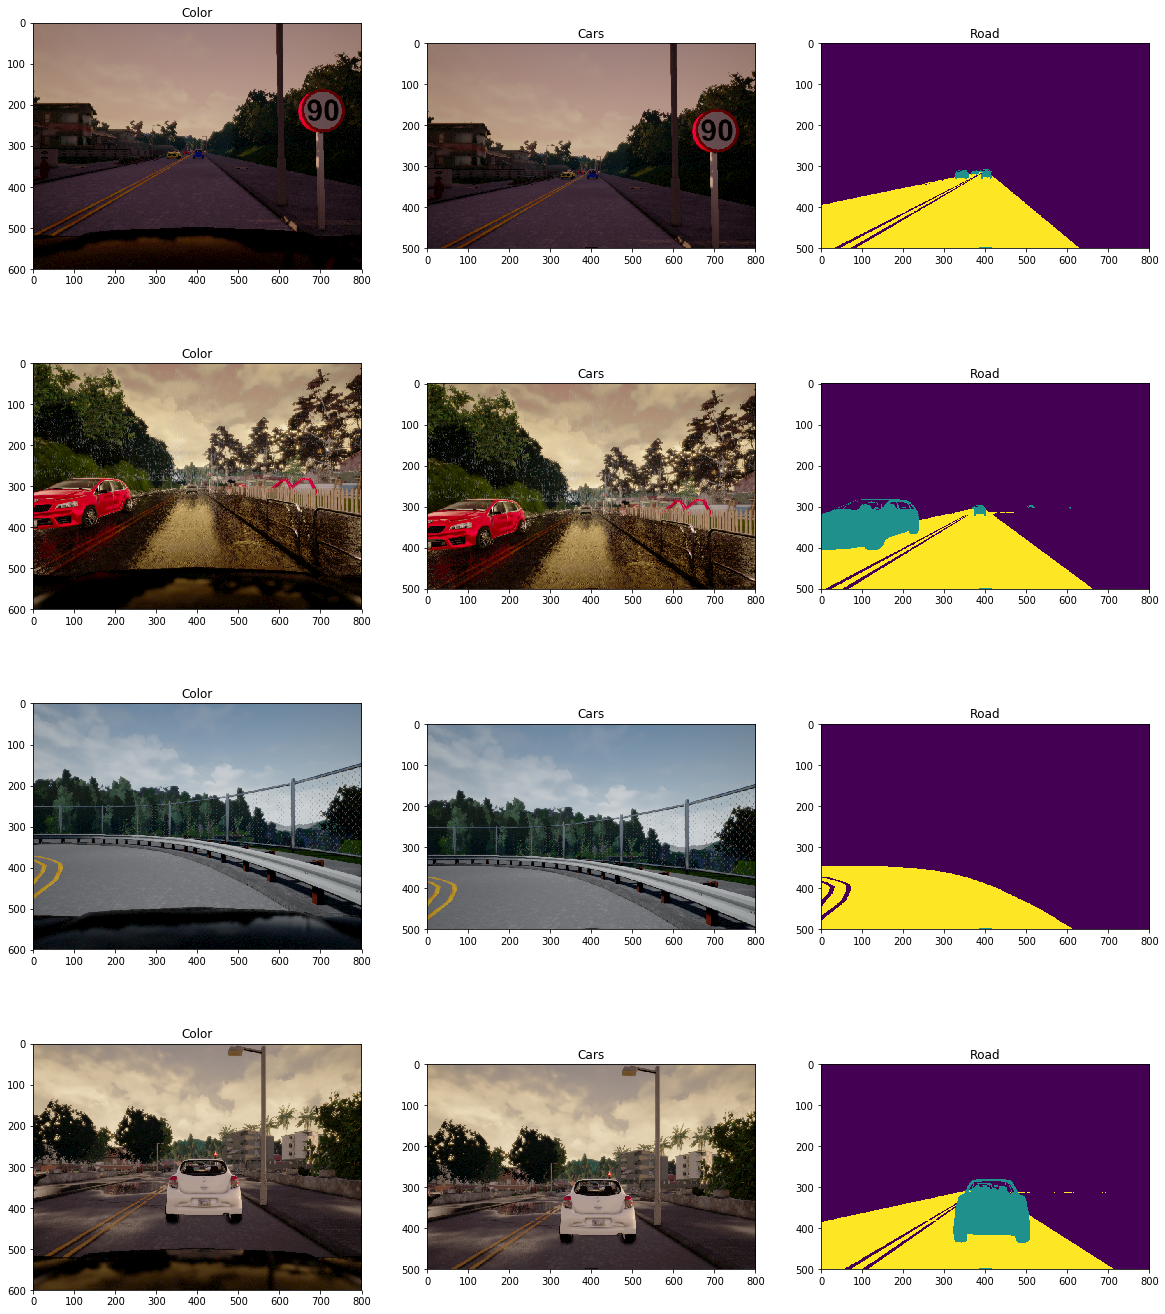

In [7]:
### print(clara_seg_data.shape[0], 'rows')
sample_rows = 4
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, clara_seg_data.sample(sample_rows).iterrows()):
    c_img = imread(c_row['image'])
    
    c_img2 = c_img[:500, :, :]
    l_img = imread(c_row['label'])
    l_img = l_img[:500, :, 0]
    
    lbls = np.zeros_like(l_img)
    lbls[l_img == 10] = 1
    lbls[l_img == 7] = 2
    
    ax1.imshow(c_img)
    ax1.set_title('Color')    
    ax2.imshow(c_img2)
    ax2.set_title('Cars')
    ax3.imshow(lbls)
    ax3.set_title('Road')

In [34]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(600, 800, 3))

for layer in base_model.layers:
    layer.trainable = False

nClasses = 3

block3_pool = base_model.get_layer('block3_pool').output
block4_pool = base_model.get_layer('block4_pool').output
block5_pool = base_model.get_layer('block5_pool').output

conv_name_base = "block%d_conv%d"
pool_name_base = "block%d_pool"
dropout_name_base = "block%d_dropout"

block = 6
step = 1

X = Conv2D(4096, (7, 7),  padding='same', activation='relu', name='block6_conv1')(block5_pool)
X = Dropout(0.5, name='block6_dropout1')(X)
X = Conv2D(4096, (1, 1), activation='relu', padding='same', name='block6_conv2')(X)
X = Dropout(0.5, name='block6_dropout2')(X)
X = Conv2D(nClasses, (1, 1), padding='same', kernel_initializer='he_normal', name='block6_conv3')(X)
X = Conv2DTranspose(nClasses, kernel_size=(4,4), strides=(2,2) , padding='same', use_bias=False, name='block6_deconv1')(X)

X2 = Conv2D(nClasses, (1, 1), kernel_initializer='he_normal', padding='same', name='block7_conv1')(block4_pool)
X2 = Cropping2D(cropping=((0, 1), (0, 0)))(X2)
X = Add(name='block7_Add')([X, X2])
X = Conv2DTranspose(nClasses, kernel_size=(4,4), strides=(2, 2), padding='same')(X)

X3 = Conv2D(nClasses, (1, 1), padding='same', name='block8_conv1')(block3_pool)
X3 = Cropping2D(cropping=((0, 3), (0, 0)))(X3)
X = Add(name='block8_Add')([X, X3])
X = Conv2DTranspose(nClasses, kernel_size=(16, 16), strides=(8, 8), padding='same', name='block8_Deconv')(X)

X = (Reshape((-1, nClasses)))(X)
X = (Activation('softmax'))(X)

model = Model(base_model.input, X)
model.summary()

ValueError: Operands could not be broadcast together with shapes (30, 50, 3) (29, 50, 3)

In [9]:
model.compile(loss='categorical_crossentropy',
      optimizer= 'adam' ,
      metrics=['accuracy'])

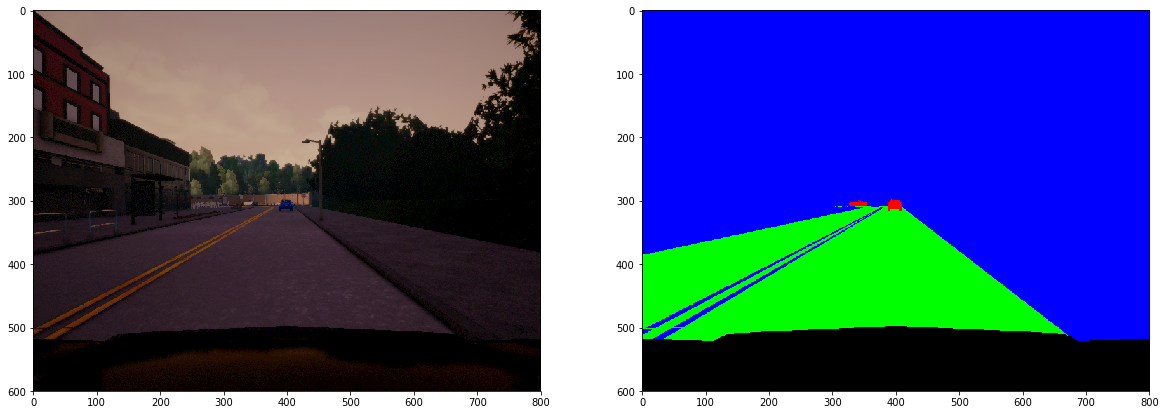

In [32]:
import cv2 

height   = 600
width    = 800
nClasses = 3

sample = clara_seg_data.sample(1)
X_input = imread(sample['image'].values[0])
Y_input = imread(sample['label'].values[0])

X_train = X_input
Y_train = np.zeros(( height , width  , nClasses ))    

y_tmp = Y_input[:, :, 0]
Y_train[:, :, 0] = (y_tmp== 10).astype(int)
Y_train[475:, :, 0] = 0
Y_train[:, :, 1] = (y_tmp== 7).astype(int)
Y_train[:, :, 2] = ~((y_tmp == 7) | (y_tmp == 10))

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(X_train)
plt.subplot(122)
plt.imshow(Y_train)


In [33]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

X_train = image.img_to_array(X_train)
X_train = np.expand_dims(X_train, axis=0)
X_train = preprocess_input(X_train)

Y_train = cv2.resize(Y_train, (576, 800))
Y_train = np.reshape(Y_train, (-1 , nClasses ))
Y_train = np.expand_dims(Y_train, axis=0)

print (X_train.shape)
print (Y_train.shape)

[0. 1.]
(1, 600, 800, 3)
(1, 460800, 3)


In [29]:
model.reset_states()
history = model.fit(X_train, Y_train, epochs=250)

Epoch 1/250
1/1 [==============================] - 0s 240ms/step - loss: 11.2810 - acc: 0.1442
Epoch 2/250
1/1 [==============================] - 0s 210ms/step - loss: 10.8904 - acc: 0.1704
Epoch 3/250
1/1 [==============================] - 0s 202ms/step - loss: 10.6258 - acc: 0.1871
Epoch 4/250
1/1 [==============================] - 0s 197ms/step - loss: 10.0213 - acc: 0.2239
Epoch 5/250
1/1 [==============================] - 0s 197ms/step - loss: 8.2054 - acc: 0.3333
Epoch 6/250
1/1 [==============================] - 0s 196ms/step - loss: 5.2160 - acc: 0.5136
Epoch 7/250
1/1 [==============================] - 0s 197ms/step - loss: 3.0708 - acc: 0.6529
Epoch 8/250
1/1 [==============================] - 0s 206ms/step - loss: 2.6738 - acc: 0.6798
Epoch 9/250
1/1 [==============================] - 0s 194ms/step - loss: 2.3128 - acc: 0.7027
Epoch 10/250
1/1 [==============================] - 0s 202ms/step - loss: 1.9669 - acc: 0.7248
Epoch 11/250
1/1 [==============================] - 0s 

Epoch 88/250
1/1 [==============================] - 0s 192ms/step - loss: 1.3761 - acc: 0.7680
Epoch 89/250
1/1 [==============================] - 0s 206ms/step - loss: 1.3761 - acc: 0.7682
Epoch 90/250
1/1 [==============================] - 0s 202ms/step - loss: 1.3773 - acc: 0.7680
Epoch 91/250
1/1 [==============================] - 0s 199ms/step - loss: 1.3727 - acc: 0.7684
Epoch 92/250
1/1 [==============================] - 0s 197ms/step - loss: 1.3722 - acc: 0.7683
Epoch 93/250
1/1 [==============================] - 0s 194ms/step - loss: 1.3721 - acc: 0.7685
Epoch 94/250
1/1 [==============================] - 0s 195ms/step - loss: 1.3657 - acc: 0.7690
Epoch 95/250
1/1 [==============================] - 0s 205ms/step - loss: 1.3666 - acc: 0.7687
Epoch 96/250
1/1 [==============================] - 0s 201ms/step - loss: 1.3655 - acc: 0.7685
Epoch 97/250
1/1 [==============================] - 0s 200ms/step - loss: 1.3652 - acc: 0.7688
Epoch 98/250
1/1 [==============================] 

Epoch 174/250
1/1 [==============================] - 0s 200ms/step - loss: 1.3157 - acc: 0.7733
Epoch 175/250
1/1 [==============================] - 0s 198ms/step - loss: 1.3167 - acc: 0.7735
Epoch 176/250
1/1 [==============================] - 0s 204ms/step - loss: 1.3201 - acc: 0.7734
Epoch 177/250
1/1 [==============================] - 0s 204ms/step - loss: 1.3232 - acc: 0.7733
Epoch 178/250
1/1 [==============================] - 0s 201ms/step - loss: 1.3165 - acc: 0.7736
Epoch 179/250
1/1 [==============================] - 0s 195ms/step - loss: 1.3129 - acc: 0.7737
Epoch 180/250
1/1 [==============================] - 0s 202ms/step - loss: 1.3063 - acc: 0.7742
Epoch 181/250
1/1 [==============================] - 0s 201ms/step - loss: 1.3069 - acc: 0.7743
Epoch 182/250
1/1 [==============================] - 0s 199ms/step - loss: 1.3128 - acc: 0.7737
Epoch 183/250
1/1 [==============================] - 0s 198ms/step - loss: 1.3190 - acc: 0.7732
Epoch 184/250
1/1 [=====================

In [13]:
X_input_test = image.img_to_array(X_input)
X_input_test = np.expand_dims(X_input_test, axis=0)
X_input_test = preprocess_input(X_input_test)
Y_pred = model.predict(X_input_test)

In [14]:
print (Y_pred.shape)

(1, 460800, 3)


In [15]:
Y_pred = Y_pred.reshape((576, 800, 3)).argmax(axis=2)
print (Y_pred.shape)
print (np.unique(Y_pred))

(576, 800)
[0 1 2]


In [18]:
y_pred_color = np.zeros( (576, 800, 3))
y_pred_color[:, :, 0]  = Y_pred == 0
y_pred_color[:, :, 1]  = Y_pred == 1
y_pred_color[:, :, 2]  = Y_pred == 2

y_pred_color = cv2.resize(y_pred_color, (600, 800))

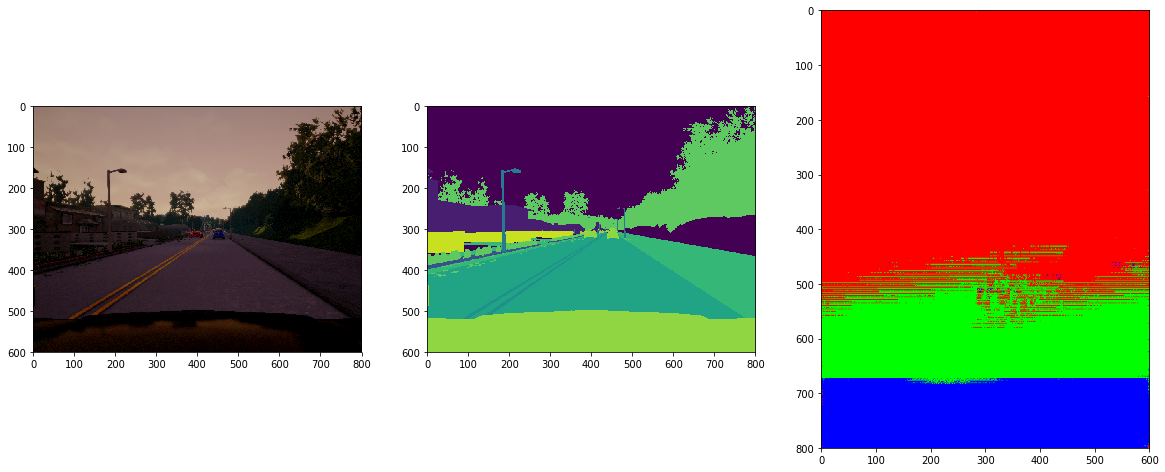

In [19]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(X_input)
plt.subplot(132)
plt.imshow(Y_input[:, :, 0])
plt.subplot(133)
plt.imshow(y_pred_color)